In [2]:
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import time
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.ops.boxes import nms
import shutil


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"romansviridov","key":"c103a2987fff7d06421de67e76fc3989"}'}

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
'chmod 600 /root/.kaggle/kaggle.json'
! kaggle competitions download -c 'tensorflow-great-barrier-reef'
!unzip tensorflow-great-barrier-reef.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train_images/video_2/4303.jpg  
  inflating: train_images/video_2/4304.jpg  
  inflating: train_images/video_2/4305.jpg  
  inflating: train_images/video_2/4306.jpg  
  inflating: train_images/video_2/4307.jpg  
  inflating: train_images/video_2/4308.jpg  
  inflating: train_images/video_2/4309.jpg  
  inflating: train_images/video_2/431.jpg  
  inflating: train_images/video_2/4310.jpg  
  inflating: train_images/video_2/4311.jpg  
  inflating: train_images/video_2/4312.jpg  
  inflating: train_images/video_2/4313.jpg  
  inflating: train_images/video_2/4314.jpg  
  inflating: train_images/video_2/4315.jpg  
  inflating: train_images/video_2/4316.jpg  
  inflating: train_images/video_2/4317.jpg  
  inflating: train_images/video_2/4318.jpg  
  inflating: train_images/video_2/4319.jpg  
  inflating: train_images/video_2/432.jpg  
  inflating: train_images/video_2/4320.jpg  
  inflating: train_images/video_2/

In [ ]:
!ls

example_sample_submission.csv  kaggle.json			  test.csv
example_test.npy	       sample_data			  train.csv
greatbarrierreef	       tensorflow-great-barrier-reef.zip  train_images


In [5]:
dataframe_train = pd.read_csv('train.csv')
dataframe_train.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations
0,0,40258,0,0,0-0,[]
1,0,40258,1,1,0-1,[]
2,0,40258,2,2,0-2,[]
3,0,40258,3,3,0-3,[]
4,0,40258,4,4,0-4,[]


In [ ]:
dir = 'train_images/'

for file in os.listdir(dir):
  folder = dir + file
  print('Папка:', folder)
  i = 0
  for img in os.listdir(folder):
      print(' ', img)
      i += 1
      if i == 5: break

Папка: train_images/video_2
  2196.jpg
  678.jpg
  9225.jpg
  2359.jpg
  665.jpg
Папка: train_images/video_0
  12329.jpg
  2196.jpg
  9225.jpg
  2359.jpg
  7918.jpg
Папка: train_images/video_1
  2196.jpg
  678.jpg
  9225.jpg
  2359.jpg
  665.jpg


In [6]:
def rename_images():
  dir = 'train_images/'
  count=0

  for file in os.listdir(dir):
    folder = dir + file
    print(folder)
    for img in os.listdir(folder):
      src_name = img
      dest_name = file.split("_")[1] + '-' + src_name.split(".")[0] + '.jpg'
      os.rename(folder + '/' + src_name, folder + '/' + dest_name)
      # subprocess.run(f"cp {src_name} {dest_name}", shell=True)
      count += 1
    print(count) # must be the same as before

In [7]:
rename_images()

train_images/video_2
8561
train_images/video_1
16793
train_images/video_0
23501


In [8]:
# image_path = 'train_images/video_' + train["video_id"].astype(str) + '/' + train["image_id"].apply(lambda x: x.split("-")[1]) + ".jpg"
filename = dataframe_train["image_id"] + ".jpg"
image_path = 'train_images/video_' + dataframe_train["video_id"].astype(str) + '/' + dataframe_train["image_id"] + ".jpg"

dataframe_train["filename"] = filename
dataframe_train["image_path"] = image_path
dataframe_train.head()

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,filename,image_path
0,0,40258,0,0,0-0,[],0-0.jpg,train_images/video_0/0-0.jpg
1,0,40258,1,1,0-1,[],0-1.jpg,train_images/video_0/0-1.jpg
2,0,40258,2,2,0-2,[],0-2.jpg,train_images/video_0/0-2.jpg
3,0,40258,3,3,0-3,[],0-3.jpg,train_images/video_0/0-3.jpg
4,0,40258,4,4,0-4,[],0-4.jpg,train_images/video_0/0-4.jpg


In [9]:
def bbox_format(x):
  annotations = eval(x)
  new_annotations = []
  if annotations:
    for annotation in annotations:
      x_min = annotation['x']
      y_min = annotation['y']
      x_max = annotation['x'] +  annotation['height']
      y_max = annotation['y'] +  annotation['width']
      new_annotations.append([x_min, y_min, x_max, y_max])
  if annotations: return new_annotations
  else: return []

In [10]:
def classes_format(x):
  annotations = eval(x)
  classes = []
  if annotations:
    for annotation in annotations:
      classes.append(1)
  if annotations: return classes
  else: return []

In [11]:
dataframe_train["bbox"] = dataframe_train["annotations"].apply(lambda x: bbox_format(x))
dataframe_train["class"] = dataframe_train["annotations"].apply(lambda x: classes_format(x))

In [13]:
dataframe_train

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,filename,image_path,bbox,class
0,0,40258,0,0,0-0,[],0-0.jpg,train_images/video_0/0-0.jpg,[],[]
1,0,40258,1,1,0-1,[],0-1.jpg,train_images/video_0/0-1.jpg,[],[]
2,0,40258,2,2,0-2,[],0-2.jpg,train_images/video_0/0-2.jpg,[],[]
3,0,40258,3,3,0-3,[],0-3.jpg,train_images/video_0/0-3.jpg,[],[]
4,0,40258,4,4,0-4,[],0-4.jpg,train_images/video_0/0-4.jpg,[],[]
...,...,...,...,...,...,...,...,...,...,...
23496,2,29859,10755,2983,2-10755,[],2-10755.jpg,train_images/video_2/2-10755.jpg,[],[]
23497,2,29859,10756,2984,2-10756,[],2-10756.jpg,train_images/video_2/2-10756.jpg,[],[]
23498,2,29859,10757,2985,2-10757,[],2-10757.jpg,train_images/video_2/2-10757.jpg,[],[]
23499,2,29859,10758,2986,2-10758,[],2-10758.jpg,train_images/video_2/2-10758.jpg,[],[]


In [ ]:
import matplotlib.patches as patches

def show_image(path, annot, axs=None):
    '''Shows an image and marks any COTS annotated within the frame.
    path: full path to the .jpg image
    annot: string of the annotation for the coordinates of COTS'''

    # This is in case we plot only 1 image
    if axs==None:
        fig, axs = plt.subplots(figsize=(15, 8))

    img = plt.imread(path)
    axs.imshow(img)

    if annot:
        for a in eval(annot):
            rect = patches.Rectangle((a["x"], a["y"]), a["width"], a["height"],
                                     linewidth=3, edgecolor="#FF6103", facecolor='none')
            axs.add_patch(rect)

    axs.axis("off")

Path: train_images/video_0/0-101.jpg
Annotation: [{'x': 266, 'y': 659, 'width': 116, 'height': 60}, {'x': 640, 'y': 52, 'width': 22, 'height': 20}]
Frame:


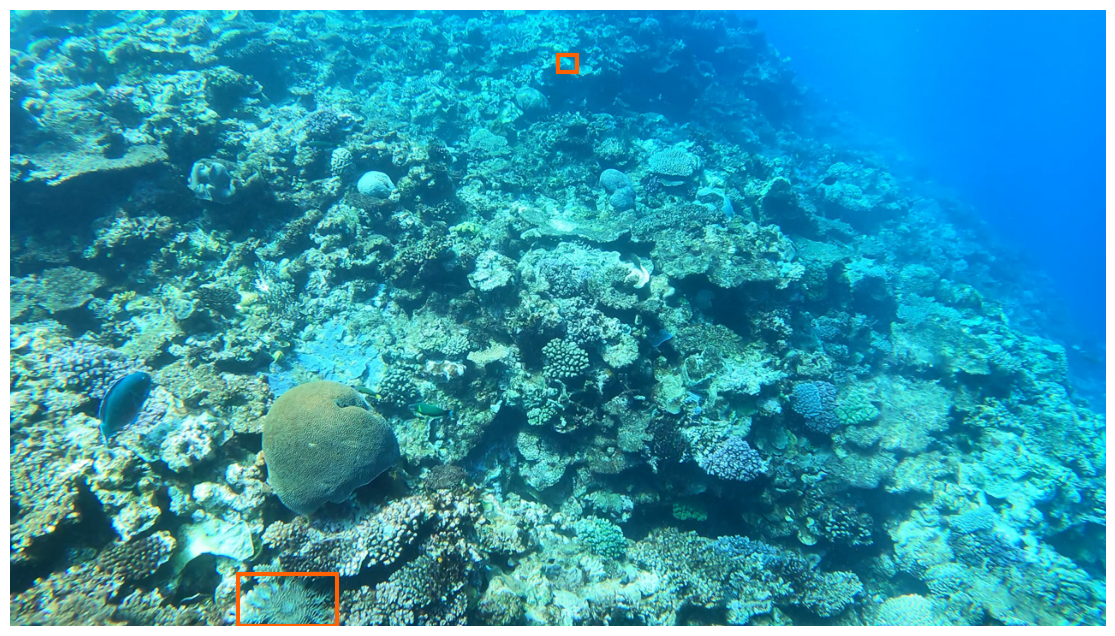

In [ ]:
path = dataframe_train.loc[101, 'image_path']
annot = dataframe_train.loc[101, 'annotations']

print("Path:",path)
print("Annotation:", annot)
print("Frame:")
show_image(path, annot, axs=None)

# Faster R-CNN

In [13]:
dataframe_train_with_annot = dataframe_train[dataframe_train['annotations'] != '[]']
dataframe_train_with_annot

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,filename,image_path,bbox,class
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",0-16.jpg,train_images/video_0/0-16.jpg,"[[559, 213, 591, 263]]",[1]
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",0-17.jpg,train_images/video_0/0-17.jpg,"[[558, 213, 590, 263]]",[1]
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",0-18.jpg,train_images/video_0/0-18.jpg,"[[557, 213, 589, 263]]",[1]
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",0-19.jpg,train_images/video_0/0-19.jpg,"[[556, 214, 588, 264]]",[1]
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",0-20.jpg,train_images/video_0/0-20.jpg,"[[555, 214, 587, 264]]",[1]
...,...,...,...,...,...,...,...,...,...,...
23369,2,29859,10628,2856,2-10628,"[{'x': 92, 'y': 532, 'width': 40, 'height': 37}]",2-10628.jpg,train_images/video_2/2-10628.jpg,"[[92, 532, 129, 572]]",[1]
23370,2,29859,10629,2857,2-10629,"[{'x': 78, 'y': 569, 'width': 40, 'height': 37}]",2-10629.jpg,train_images/video_2/2-10629.jpg,"[[78, 569, 115, 609]]",[1]
23371,2,29859,10630,2858,2-10630,"[{'x': 65, 'y': 606, 'width': 41, 'height': 37}]",2-10630.jpg,train_images/video_2/2-10630.jpg,"[[65, 606, 102, 647]]",[1]
23372,2,29859,10631,2859,2-10631,"[{'x': 51, 'y': 643, 'width': 44, 'height': 37}]",2-10631.jpg,train_images/video_2/2-10631.jpg,"[[51, 643, 88, 687]]",[1]


<ipython-input-38-e6cbf3df0897>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_train_with_annot["num_annotations"] = dataframe_train_with_annot["annotations"].apply(lambda x: len(eval(x)))
<ipython-input-38-e6cbf3df0897>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='num_annotations', data=dataframe_train_with_annot, palette = "colorblind")


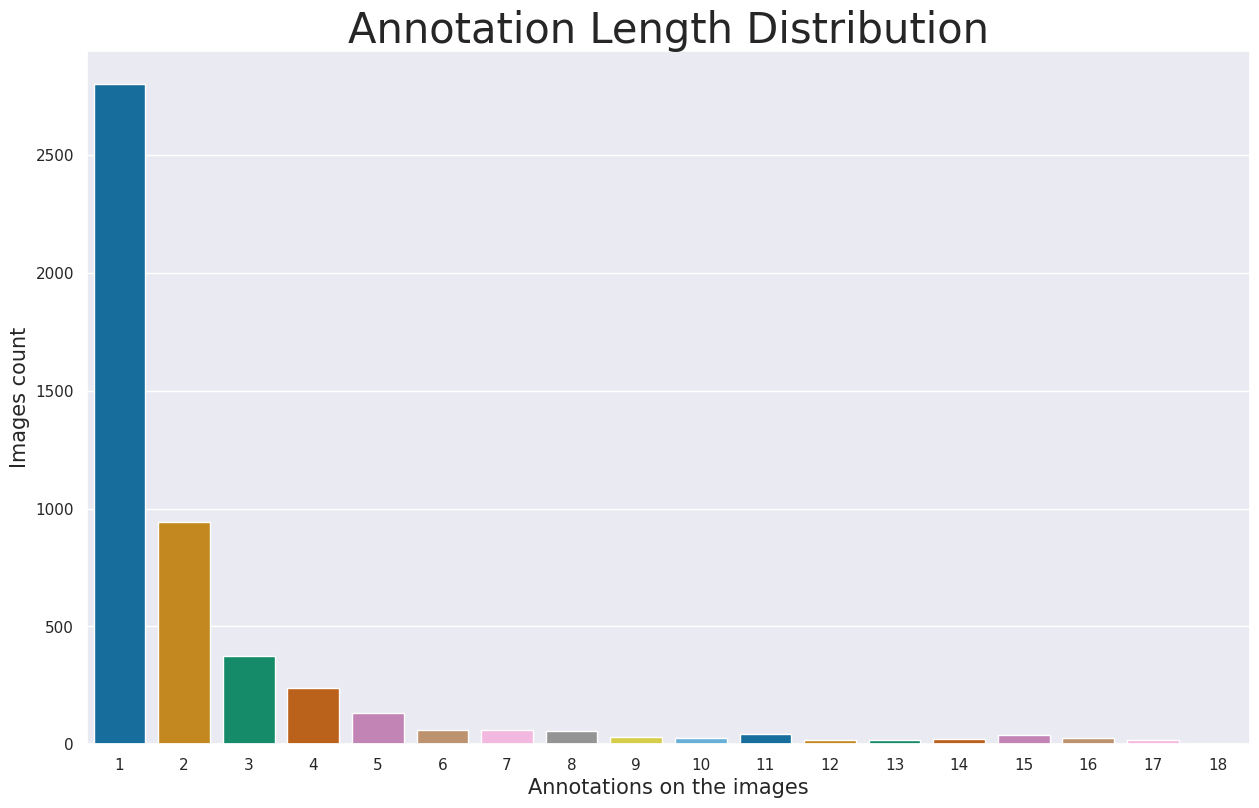

In [ ]:
sns.set_theme(rc={'figure.figsize':(15,9)})
dataframe_train_with_annot["num_annotations"] = dataframe_train_with_annot["annotations"].apply(lambda x: len(eval(x)))

sns.countplot(x='num_annotations', data=dataframe_train_with_annot, palette = "colorblind")
plt.title("Annotation Length Distribution", fontsize = 30)
plt.xlabel("Annotations on the images", fontsize = 15)
plt.ylabel("Images count", fontsize = 15)
plt.show()

In [ ]:
dataframe_train_with_annot["no_annotations"] = dataframe_train_with_annot["annotations"].apply(lambda x: len(eval(x)))

<ipython-input-29-e87de68003aa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_train_with_annot["no_annotations"] = dataframe_train_with_annot["annotations"].apply(lambda x: len(eval(x)))


In [32]:
from sklearn.model_selection import train_test_split

images_count = 500

df_500 = dataframe_train_with_annot.sample(n = images_count)
X_train_500, X_val_500 = train_test_split(df_500, test_size=0.2, random_state=42)
X_train_500, X_val_500 = X_train_500.reset_index(drop=True), X_val_500.reset_index(drop=True)
print('df_train size:', X_train_500.shape[0])
print('  df_val size:', X_val_500.shape[0])


df_train size: 400
  df_val size: 100


In [ ]:
from PIL import Image

class MyDataset(Dataset):

    def __init__(self, dataframe, img_path):

        self.df = dataframe
        self.img_path = img_path

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        print("Index:", index)
        ##//img_name = self.df.loc[index, 'filename']
        # boxes = torch.Tensor(self.df.loc[index, 'bbox']).to(torch.float)
        ##//boxes = torch.as_tensor(self.df.loc[index, 'bbox'], dtype=torch.float32)
        ##//labels = torch.Tensor(self.df.loc[index, 'class']).to(torch.int64)
        # area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 0])
        # iscrowd = torch.zeros(labels.shape[0], dtype=torch.int64)

        ##//target = {}
        ##//target['boxes'] = boxes
        ##//target['labels'] = labels

        ##//img = cv2.imread(os.path.join(self.img_path, img_name))/255.0
        ##//img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)
        # img_path = os.path.join(self.img_path, img_name)
        # img = Image.open(img_path).convert("RGB")
        ##//return img, target

        img_name = self.df.iloc[index]['filename']
        # Загружаем изображение и нормализуем его
        img_path = os.path.join(self.img_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Преобразование BGR в RGB
        img = img / 255.0  # Нормализация изображения до диапазона [0, 1]
        img = torch.from_numpy(img).permute(2, 0, 1).float()  # Преобразование в тензор

        # Получаем аннотации
        boxes = self.df.iloc[index]['bbox']
        # Преобразование координат bbox в тензор float32
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Получаем метки классов
        #labels = self.df.iloc[index]['class']
        #labels = torch.tensor(labels, dtype=torch.int64)
        #labels = self.df.iloc[index]['class']
        #if labels:  # Проверка наличия меток классов
        #  labels = [torch.tensor(label, dtype=torch.int64) for label in labels]
        #  labels = torch.stack(labels)
        #else:
        # Если меток классов нет, создаем пустой тензор
        #  labels = torch.tensor([], dtype=torch.int64)
        class_list = self.df.at[index, 'class']
        if index < len(self.df):  # Проверяем, что индекс не превышает длину набора данных
          if class_list:  # Проверяем, что список не пуст
            labels = torch.tensor(class_list, dtype=torch.int64)
          else:
            labels = torch.tensor([], dtype=torch.int64)  # Создаем пустой тензор, если список пуст
        else:
          print("Index out of range:", index)
        # Формируем целевой словарь
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return img, target

In [39]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import os
import pandas as pd

class Starfish(Dataset):
    def __init__(self, dataframe, img_path):
        self.df = dataframe
        self.img_path = img_path

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_name = self.df.loc[index, 'filename']
        class_list = self.df.loc[index, 'class']
        bboxes = self.df.loc[index, 'bbox']

        # Проверка корректности данных
        if not isinstance(class_list, list):
            #class_list = [class_list]
            class_list = class_list.tolist()[0]
        #if not isinstance(bboxes, list):
        print(len(bboxes))
        #boxes = bboxes.tolist()[0]
         #   bboxes = [bboxes]
        print(class_list)

        #assert len(class_list) == len(bboxes), f"Количество меток и bbox не совпадает. Index: {index}, Filename: {img_name}"

        labels = torch.tensor(class_list, dtype=torch.int64)

        #img_name = self.df.iloc[index]['filename']
        # Загружаем изображение и нормализуем его
        #img_path = os.path.join(self.img_path, img_name)
        #img = cv2.imread(img_path)
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Преобразование BGR в RGB
        #img = img / 255.0  # Нормализация изображения до диапазона [0, 1]
        #img = torch.from_numpy(img).permute(2, 0, 1).float()  # Преобразование в тензор
        boxes = torch.tensor(bboxes, dtype=torch.float32)

        assert len(class_list) == len(boxes), f"Количество меток и bbox не совпадает. Index: {index}, Filename: {img_name}"
        print(f'len of bbox: {len(boxes)}')
        print(f'len of class_list: {len(class_list)}')


        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        img_path_full = os.path.join(self.img_path, img_name)
        img = cv2.imread(img_path_full)
        if img is None:
            raise ValueError(f"Не удалось загрузить изображение по пути: {img_path_full}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img / 255.0
        img = torch.from_numpy(img).permute(2, 0, 1).to(torch.float)

        return img, target

In [33]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model():
    model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn()
    num_classes = 2
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [34]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [35]:
def select_img_with_ann(dataset, datasep_type):
  newpath = 'images/' + datasep_type + '/'
  if not os.path.exists(newpath):
    os.makedirs(newpath)

#select img with annotations for .jpg
  img_annot_jpg = []
  for i,data in dataset.iterrows() :
    if not data["annotations"] == "[]":
      img_annot_jpg.append(data["image_path"])
  print(len(img_annot_jpg)) # must be the same as before
  return img_annot_jpg

In [ ]:
!rm -rf 'images'

In [36]:
train_list_image_with_ann = select_img_with_ann(X_train_500, 'train')
test_list_image_with_ann = select_img_with_ann(X_val_500, 'val')


400
100


In [40]:
def image_to_folders(type_dataset, list_img_annot_jpg):

  dir = 'train_images/'
  dest = 'images/' + type_dataset + '/'

  count=0

  for file in os.listdir(dir):
    folder = dir + file
    print(folder)
    for img in os.listdir(folder):
    #img_path = os.path.join(folder,img)
      img_path = folder + '/' + img
      # print(img_path)

      if img_path in list_img_annot_jpg:
        count=count+1
        shutil.copy(img_path, dest)
    print(count) #must be the same as before

In [41]:
image_to_folders('train', train_list_image_with_ann)

train_images/video_2
67
train_images/video_1
238
train_images/video_0
400


In [ ]:
c = 0
for filename in os.listdir('/content/images/train'):
  if filename.endswith("jpg"):
        # Your code comes here such as
    # print(filename)
    c += 1
print(c)

0


In [42]:
image_to_folders('val', test_list_image_with_ann)

train_images/video_2
12
train_images/video_1
56
train_images/video_0
100


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

train_dataset = MyDataset(X_train_500, '/content/images/train')
val_dataset = MyDataset(X_val_500, '/content/images/val')

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 35.3MB/s]


In [43]:
from sklearn.metrics import fbeta_score

def val_f2(val_dataloader, model, device, threshold=0.5):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in val_dataloader:
            images, targets = data
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for target, output in zip(targets, outputs):
                true_labels = target['labels'].cpu().numpy()
                predicted_scores = output['scores'].cpu().numpy()
                predicted_labels = (predicted_scores > threshold).astype(int)

                y_true.extend(true_labels)
                y_pred.extend(predicted_labels)

    # Вычисление метрики F2-меры
    f2 = fbeta_score(y_true, y_pred, beta=2, average='binary')
    return f2

# Пример использования
val_dataset = Starfish(X_val_500, '/content/images/val')  # Используем тот же датасет для простоты примера
val_data_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model().to(device)  # Предполагаем, что get_model() определена ранее

f2_score = val_f2(val_data_loader, model, device)
print(f'F2 Score: {f2_score}')

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 45.9MB/s]


3
[1, 1, 1]
len of bbox: 3
len of class_list: 3
1
[1]
len of bbox: 1
len of class_list: 1
10
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
len of bbox: 10
len of class_list: 10
3
[1, 1, 1]
len of bbox: 3
len of class_list: 3
1
[1]
len of bbox: 1
len of class_list: 1
2
[1, 1]
len of bbox: 2
len of class_list: 2
1
[1]
len of bbox: 1
len of class_list: 1
1
[1]
len of bbox: 1
len of class_list: 1
1
[1]
len of bbox: 1
len of class_list: 1
1
[1]
len of bbox: 1
len of class_list: 1
17
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
len of bbox: 17
len of class_list: 17
1
[1]
len of bbox: 1
len of class_list: 1
2
[1, 1]
len of bbox: 2
len of class_list: 2
1
[1]
len of bbox: 1
len of class_list: 1
4
[1, 1, 1, 1]
len of bbox: 4
len of class_list: 4
1
[1]
len of bbox: 1
len of class_list: 1
2
[1, 1]
len of bbox: 2
len of class_list: 2
1
[1]
len of bbox: 1
len of class_list: 1
4
[1, 1, 1, 1]
len of bbox: 4
len of class_list: 4
2
[1, 1]
len of bbox: 2
len of class_list: 2
1
[1]
len of bbox: 1
len of class_lis

ValueError: Found input variables with inconsistent numbers of samples: [213, 9785]

In [ ]:
def train(train_dataloader):
    model.train()
    running_loss = 0
    for i, data in enumerate(train_dataloader):
      optimizer.zero_grad()
      #print('data[0]', data[0])
      #print('data[1]', data[1])
      images, targets = data[0], data[1]
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      loss_dict = model(images, targets)
      loss = sum(loss for loss in loss_dict.values())
      running_loss += loss.item()
      loss.backward()
      optimizer.step()
      #if i % 1 == 0:
        #print(f"\tИтерация #{i} loss: {loss}")
      print(f"\tИтерация #{i} loss: {loss}")
    train_loss = running_loss/len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader):
    running_loss = 0
    for data in val_dataloader:
      optimizer.zero_grad()
      images, targets = data[0], data[1]
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      with torch.no_grad():
        loss_dict = model(images, targets)
      loss_dict = model(images, targets)
      loss = sum(loss for loss in loss_dict.values())
      running_loss += loss.item()
    val_loss = running_loss/len(val_dataloader.dataset)
    return val_loss

In [ ]:
train_losses = []
val_losses = []
try:
  for epoch in range(5):
    start = time.time()
    train_loss = train(train_data_loader)
    val_loss = val(val_data_loader)
    scheduler.step()
    print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")
    end = time.time()
    print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
except KeyboardInterrupt:
  print('Прервано пользователем')


	Итерация #0 loss: 1.5007963180541992
	Итерация #1 loss: 1.481192708015442
	Итерация #2 loss: 1.4056073427200317
	Итерация #3 loss: 1.2804839611053467
	Итерация #4 loss: 1.1728014945983887
	Итерация #5 loss: 1.1007747650146484
	Итерация #6 loss: 1.010995626449585
	Итерация #7 loss: 0.9531383514404297
	Итерация #8 loss: 0.8761678338050842
	Итерация #9 loss: 0.8219243288040161
	Итерация #10 loss: 0.8439028859138489
	Итерация #11 loss: 0.7912222743034363
	Итерация #12 loss: 0.7359615564346313
	Итерация #13 loss: 0.7373028993606567
	Итерация #14 loss: 0.7582733631134033
	Итерация #15 loss: 0.7656591534614563
	Итерация #16 loss: 0.7792986035346985
	Итерация #17 loss: 0.771217405796051
	Итерация #18 loss: 0.8298824429512024
	Итерация #19 loss: 0.8213645815849304
	Итерация #20 loss: 0.7868886590003967
	Итерация #21 loss: 0.6973322033882141
	Итерация #22 loss: 0.7022409439086914
	Итерация #23 loss: 0.7466944456100464
	Итерация #24 loss: 0.6923013925552368
Эпоха #0 train_loss: 0.057658563852310

In [44]:
import torch
from sklearn.metrics import precision_score, recall_score, fbeta_score

def train(train_dataloader, model, optimizer, device):
    model.train()
    running_loss = 0
    for data in train_dataloader:
        images, targets = data[0], data[1]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = running_loss / len(train_dataloader.dataset)
    return train_loss

def val(val_dataloader, model, device, threshold=0.5):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in val_dataloader:
            images, targets = data[0], data[1]
            outputs = model(images)
            for output in outputs:
                predictions = (output['labels'][0]['labels'].squeeze() > threshold).float()
                y_true.extend(targets['labels'].cpu().numpy())
                y_pred.extend(predictions.cpu().numpy())
    # Вычисление метрики F2-меры
    f2 = fbeta_score(y_true, y_pred, beta=2, average='binary')
    return f2

In [45]:
import time

train_losses = []
f2_scores = []

try:
    for epoch in range(5):
        start = time.time()
        train_loss = train(train_data_loader, model, optimizer, device)
        val_loss = val(val_data_loader, model, device)
        scheduler.step()
        print(f"Эпоха #{epoch} train_loss: {train_loss}, val_loss: {val_loss}")
        end = time.time()
        print(f"Потрачено {round((end - start) / 60, 1)} минут на {epoch} эпоху")
        train_losses.append(train_loss)
        f2_scores.append(val_loss)
except KeyboardInterrupt:
    print('Прервано пользователем')


NameError: name 'train_data_loader' is not defined

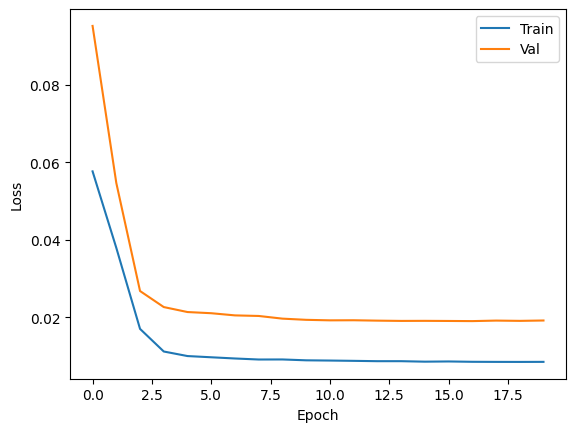

In [ ]:
fig, ax  = plt.subplots()
ax.plot(train_losses, label='Train')
ax.plot(f2_scores, label='Val')
ax.set(xlabel='Epoch', ylabel='Loss')
ax.legend()

In [ ]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union = box1_area + box2_area - intersection

    return intersection / union

In [ ]:
def train_model(model, data_loader, device, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {losses.item()}')

def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    tp = 0
    fp = 0
    fn = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)
            # images, targets = data[0], data[1]
            # images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].cpu().numpy()
                true_boxes = targets[i]['boxes'].cpu().numpy()

                matched = set()

                for pred_box in pred_boxes:
                    if len(true_boxes) == 0:
                        fp += 1
                        continue
                    ious = [compute_iou(pred_box, true_box) for true_box in true_boxes]
                    max_iou = max(ious)
                    max_iou_idx = ious.index(max_iou)

                    if max_iou >= iou_threshold and max_iou_idx not in matched:
                        tp += 1
                        matched.add(max_iou_idx)
                    else:
                        fp += 1

                fn += len(true_boxes) - len(matched)

    return tp, fp, fn


In [ ]:
def calculate_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = get_model().to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

In [ ]:
num_epochs = 10
train_model(model, train_data_loader, device, optimizer, num_epochs)

Epoch 1/10, Loss: 0.19101935625076294
Epoch 2/10, Loss: 0.14230704307556152
Epoch 3/10, Loss: 0.18244078755378723
Epoch 4/10, Loss: 0.17963166534900665
Epoch 5/10, Loss: 0.16629192233085632
Epoch 6/10, Loss: 0.10469560325145721
Epoch 7/10, Loss: 0.13300758600234985
Epoch 8/10, Loss: 0.11930981278419495
Epoch 9/10, Loss: 0.10000865161418915
Epoch 10/10, Loss: 0.12464483827352524


In [ ]:
tp, fp, fn = evaluate_model(model, val_data_loader, device)
precision, recall, f1_score = calculate_metrics(tp, fp, fn)

In [ ]:
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')

# YOLOv8n

In [46]:
dataframe_train_with_annot = dataframe_train[dataframe_train['annotations'] != '[]']
dataframe_train_with_annot

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,filename,image_path,bbox,class
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",0-16.jpg,train_images/video_0/0-16.jpg,"[[559, 213, 591, 263]]",[1]
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",0-17.jpg,train_images/video_0/0-17.jpg,"[[558, 213, 590, 263]]",[1]
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",0-18.jpg,train_images/video_0/0-18.jpg,"[[557, 213, 589, 263]]",[1]
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",0-19.jpg,train_images/video_0/0-19.jpg,"[[556, 214, 588, 264]]",[1]
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",0-20.jpg,train_images/video_0/0-20.jpg,"[[555, 214, 587, 264]]",[1]
...,...,...,...,...,...,...,...,...,...,...
23369,2,29859,10628,2856,2-10628,"[{'x': 92, 'y': 532, 'width': 40, 'height': 37}]",2-10628.jpg,train_images/video_2/2-10628.jpg,"[[92, 532, 129, 572]]",[1]
23370,2,29859,10629,2857,2-10629,"[{'x': 78, 'y': 569, 'width': 40, 'height': 37}]",2-10629.jpg,train_images/video_2/2-10629.jpg,"[[78, 569, 115, 609]]",[1]
23371,2,29859,10630,2858,2-10630,"[{'x': 65, 'y': 606, 'width': 41, 'height': 37}]",2-10630.jpg,train_images/video_2/2-10630.jpg,"[[65, 606, 102, 647]]",[1]
23372,2,29859,10631,2859,2-10631,"[{'x': 51, 'y': 643, 'width': 44, 'height': 37}]",2-10631.jpg,train_images/video_2/2-10631.jpg,"[[51, 643, 88, 687]]",[1]


In [47]:
def format_yolo_annotations(x):
    annotations = eval(x)
    new_annotations = ''

    img_h=720
    img_w=1280

    if annotations:
        for annot in annotations:
            current_category = 0
            x = annot["x"]
            y = annot["y"]
            w = annot["width"]
            h = annot["height"]

            # Finding midpoints
            x_centre = (x + (x+w))/2
            y_centre = (y + (y+h))/2

            # Normalization
            x_centre = x_centre / img_w
            y_centre = y_centre / img_h
            w = w / img_w
            h = h / img_h

            # Limiting upto fix number of decimal places
            x_centre = format(x_centre, '.6f')
            y_centre = format(y_centre, '.6f')
            w = format(w, '.6f')
            h = format(h, '.6f')

            new_annotations = new_annotations + (f"{current_category} {x_centre} {y_centre} {w} {h}\n")


    if new_annotations: return new_annotations
    else: return ''

In [48]:
dataframe_train_with_annot["yolo_annot"] = dataframe_train_with_annot["annotations"].apply(lambda x: format_yolo_annotations(x))

<ipython-input-48-ef11e31b522b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_train_with_annot["yolo_annot"] = dataframe_train_with_annot["annotations"].apply(lambda x: format_yolo_annotations(x))


In [49]:
dataframe_train_with_annot

,video_id,sequence,video_frame,sequence_frame,image_id,annotations,filename,image_path,bbox,class,yolo_annot
16,0,40258,16,16,0-16,"[{'x': 559, 'y': 213, 'width': 50, 'height': 32}]",0-16.jpg,train_images/video_0/0-16.jpg,"[[559, 213, 591, 263]]",[1],0 0.456250 0.318056 0.039062 0.044444\n
17,0,40258,17,17,0-17,"[{'x': 558, 'y': 213, 'width': 50, 'height': 32}]",0-17.jpg,train_images/video_0/0-17.jpg,"[[558, 213, 590, 263]]",[1],0 0.455469 0.318056 0.039062 0.044444\n
18,0,40258,18,18,0-18,"[{'x': 557, 'y': 213, 'width': 50, 'height': 32}]",0-18.jpg,train_images/video_0/0-18.jpg,"[[557, 213, 589, 263]]",[1],0 0.454688 0.318056 0.039062 0.044444\n
19,0,40258,19,19,0-19,"[{'x': 556, 'y': 214, 'width': 50, 'height': 32}]",0-19.jpg,train_images/video_0/0-19.jpg,"[[556, 214, 588, 264]]",[1],0 0.453906 0.319444 0.039062 0.044444\n
20,0,40258,20,20,0-20,"[{'x': 555, 'y': 214, 'width': 50, 'height': 32}]",0-20.jpg,train_images/video_0/0-20.jpg,"[[555, 214, 587, 264]]",[1],0 0.453125 0.319444 0.039062 0.044444\n
...,...,...,...,...,...,...,...,...,...,...,...
23369,2,29859,10628,2856,2-10628,"[{'x': 92, 'y': 532, 'width': 40, 'height': 37}]",2-10628.jpg,train_images/video_2/2-10628.jpg,"[[92, 532, 129, 572]]",[1],0 0.087500 0.764583 0.031250 0.051389\n
23370,2,29859,10629,2857,2-10629,"[{'x': 78, 'y': 569, 'width': 40, 'height': 37}]",2-10629.jpg,train_images/video_2/2-10629.jpg,"[[78, 569, 115, 609]]",[1],0 0.076563 0.815972 0.031250 0.051389\n
23371,2,29859,10630,2858,2-10630,"[{'x': 65, 'y': 606, 'width': 41, 'height': 37}]",2-10630.jpg,train_images/video_2/2-10630.jpg,"[[65, 606, 102, 647]]",[1],0 0.066797 0.867361 0.032031 0.051389\n
23372,2,29859,10631,2859,2-10631,"[{'x': 51, 'y': 643, 'width': 44, 'height': 37}]",2-10631.jpg,train_images/video_2/2-10631.jpg,"[[51, 643, 88, 687]]",[1],0 0.057031 0.918750 0.034375 0.051389\n


In [52]:
from sklearn.model_selection import train_test_split

X_train_with_annot, X_val_with_annot = train_test_split(dataframe_train_with_annot, test_size=0.2, random_state=42)

In [54]:
def select_img_with_ann(dataset, datasep_type):
  newpath = 'images/' + datasep_type + '/'
  if not os.path.exists(newpath):
    os.makedirs(newpath)

  img_annot_jpg = []
  for i,data in dataset.iterrows() :
    if not data["annotations"] == "[]":
      img_annot_jpg.append(data["image_path"])
  print(len(img_annot_jpg))
  return img_annot_jpg

In [55]:
train_list_image_with_ann = select_img_with_ann(X_train_with_annot, 'train')
test_list_image_with_ann = select_img_with_ann(X_val_with_annot, 'test')

3935
984


In [56]:
def image_to_folders(type_dataset, list_img_annot_jpg):

  dir = 'train_images/'
  dest = 'images/' + type_dataset + '/'

  if not os.path.exists(dest):
    os.makedirs(dest)

  count=0

  for file in os.listdir(dir):
    folder = dir + file
    print(folder)
    for img in os.listdir(folder):
    #img_path = os.path.join(folder,img)
      img_path = folder + '/' + img
      # print(img_path)

      if img_path in list_img_annot_jpg:
        count=count+1
        shutil.copy(img_path, dest)
    print(count) #must be the same as before

In [86]:
!rm -rf images

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [59]:
image_to_folders('train', train_list_image_with_ann)

train_images/video_2
544
train_images/video_1
2235
train_images/video_0
3935


In [60]:
image_to_folders('test', test_list_image_with_ann)

train_images/video_2
133
train_images/video_1
541
train_images/video_0
984


In [61]:
def create_labels (dataset, dataset_type):
  #create labels directory for yolov8
  dest_labels = 'labels/' + dataset_type + '/'
  if not os.path.exists(dest_labels):
    os.makedirs(dest_labels)

  count=0
  #select records with annotations for .txt and copy them in the right directory
  for i,data in dataset.iterrows() :
    if not data["annotations"] == "[]":
      count=count+1
      file =  str(data["image_id"]) + ".txt"
      f = open(os.path.join(dest_labels,file),"w")
      f.write(data["yolo_annot"])
      f.close()

  print(count) #must be the same as before

In [71]:
!rm -rf labels

In [72]:
create_labels(X_train_with_annot, 'train')

3935


In [73]:
create_labels(X_val_with_annot, 'test')

984


In [ ]:
num= 100 #put the choosen number to be checked
path_l = 'labels/train/'
path_i = 'images/train/'
annot =  list(train[train["video_frame"]==num]["annotations"])[0]


label = str(num)+".txt"
image = str(num)+".jpg"
print ("Image real path: " + train["image_path"][num])
print ("Image yolo path: " + os.path.join(path_i,image))
print("Annotations: " + train["annotations"][num])
print("\n")
print("Label yolo path: " + os.path.join(path_l,label))
f = open(os.path.join(path_l, label), 'r')
print("Annotations yolo format: " +f.read())
f.close()
show_image(os.path.join(path_i,image), annot, axs=None)


In [68]:
!pip install ultralytics
from ultralytics import YOLO

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.6/779.6 kB 6.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [94]:
yolov8n = YOLO("yolov8n.yaml")
yolov8n_results = yolov8n.train(data = "/content/cots.yaml", epochs = 50)

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/cots.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

In [93]:
yolov8s = YOLO("yolov8s.yaml")
yolov8s_results = yolov8s.train(data = "/content/cots.yaml", epochs = 50)

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/cots.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

In [92]:
yolov8m = YOLO("yolov8m.yaml")
yolov8m_results = yolov8m.train(data = "/content/cots.yaml", epochs = 50)

Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.yaml, data=/content/cots.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

In [83]:
images_count = 2000

df_2k = dataframe_train_with_annot.sample(n = images_count)
X_train_2k, X_val_2k = train_test_split(df_2k, test_size=0.2, random_state=42)
X_train_2k, X_val_2k = X_train_2k.reset_index(drop=True), X_val_2k.reset_index(drop=True)
print('df_train size:', X_train_2k.shape[0])
print('  df_val size:', X_val_2k.shape[0])

train_list_image_with_ann = select_img_with_ann(X_train_2k, 'train')
test_list_image_with_ann = select_img_with_ann(X_val_2k, 'test')

yolov8l = YOLO("yolov8l.yaml")
yolov8l_results = yolov8l.train(data = "/content/cots.yaml", epochs = 50)

df_train size: 40
  df_val size: 10
Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.yaml, data=/content/cots.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

train: Scanning /content/labels/train.cache... 3935 images, 0 backgrounds, 1 corrupt: 100%|██████████| 3935/3935 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/images/train/0-9470.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0021]
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/labels/test.cache... 984 images, 0 backgrounds, 0 corrupt: 100%|██████████| 984/984 [00:00<?, ?it/s]


Plotting labels to runs/detect/train12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train12
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/246 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 52.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 66.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with an OutOfMemoryError: CUDA out of memory. Tried to allocate 78.00 MiB. GPU  (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:924.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv

OutOfMemoryError: CUDA out of memory. Tried to allocate 14.00 MiB. GPU 

In [91]:
!rm -rf images

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [88]:
image_to_folders('train', X_train_2k)
image_to_folders('test', X_val_2k)

train_images/video_2
0
train_images/video_1
0
train_images/video_0
0
train_images/video_2
0
train_images/video_1
0
train_images/video_0
0


In [87]:
!rm -rf labels

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
create_labels(X_train_2k, 'train')
create_labels(X_val_2k, 'test')

In [82]:
images_count = 1000

df_1k = dataframe_train_with_annot.sample(n = images_count)
X_train_1k, X_val_1k = train_test_split(df_1k, test_size=0.2, random_state=42)
X_train_1k, X_val_1k = X_train_1k.reset_index(drop=True), X_val_1k.reset_index(drop=True)
print('df_train size:', X_train_1k.shape[0])
print('  df_val size:', X_val_1k.shape[0])

yolov8x = YOLO("yolov8x.yaml")
yolov8x_results = yolov8x.train(data = "/content/cots.yaml", epochs = 50)

df_train size: 800
  df_val size: 200
Ultralytics YOLOv8.2.28 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.yaml, data=/content/cots.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 